Assignment 4:

1. You have to create one supervisor 
2. Router 
3.  3.1 llm call (llm node)
    3.2 RAG (rag node)
    3.3 web crawler (fetch the info in realtime from internet ) 

4. Created one more node for validation of generated output  -> Explore validation part 
5. If validation going to be faild in that again go to supervisor and then supervisor will again decide what needs to be call next
6. Once the validation will pass then only generated the final output

In [200]:
from langchain_groq.chat_models import ChatGroq
from langchain_core.prompts import PromptTemplate
from langchain.output_parsers import PydanticOutputParser
from langchain_core.output_parsers import StrOutputParser
from dotenv import load_dotenv
import os

from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.graph.message import MessagesState, add_messages
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.document_loaders import TextLoader, DirectoryLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma
from langchain_huggingface.embeddings import HuggingFaceEmbeddings
from langchain_core.runnables import RunnablePassthrough

from pydantic import BaseModel, Field

load_dotenv()

True

In [201]:
groq_api_key = os.getenv('GROQ_API_KEY')

In [202]:
model = ChatGroq(groq_api_key=groq_api_key, model="gemma2-9b-it")

model.invoke("hi").content

'Hello! 👋  How can I help you today?\n'

In [203]:
tavily_tool = TavilySearchResults()

In [204]:
loader = DirectoryLoader('../data', glob='./*.txt', loader_cls=TextLoader)
docs = loader.load()

In [205]:
embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

In [206]:
splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
documents = splitter.split_documents(docs)

In [207]:
db = Chroma.from_documents(documents=documents, embedding=embeddings)

In [208]:
retriever = db.as_retriever()

In [209]:
retriever.invoke("gdp of usa?")

[Document(metadata={'source': '..\\data\\usa.txt'}, page_content='U.S. GDP – Size, Composition, and Global Share'),
 Document(metadata={'source': '..\\data\\usa.txt'}, page_content='U.S. GDP – Size, Composition, and Global Share'),
 Document(metadata={'source': '..\\data\\usa.txt'}, page_content='U.S. GDP – Size, Composition, and Global Share'),
 Document(metadata={'source': '..\\data\\usa.txt'}, page_content='U.S. GDP – Size, Composition, and Global Share')]

In [210]:
class TopicSelector(BaseModel):
    Topic: str = Field(description="Topic to be select 'LLM', 'RAG', 'Web'")
    Reason: str = Field(description="Reason to select the topic")

In [211]:
def supervisor(state: MessagesState):
    print("--> Supervisor <--")
    question = state['messages'][0]
    
    template = """You are an ai assistant tasked with identify the appropriate topic based on the given question {question} \n{format_instructions}.
    topics are : 'LLM', 'RAG', 'Web'
    RAG: If the question is related to the USA 
    WEB: If the question is related to current situvation
    LLM: If the question is related to general question
    """
    parser = PydanticOutputParser(pydantic_object=TopicSelector)
    
    prompt = PromptTemplate(
        template=template,
        input_variables=['question'],
        partial_variables={"format_instructions": parser.get_format_instructions()}
    )
    
    chain = prompt | model | parser 
    
    result = chain.invoke(question)
    print("Result: ", result)
    return {"messages": [result.Topic]}

In [212]:
state = {"messages": ["who is the present president in india?"]}

In [213]:
supervisor(state)

--> Supervisor <--
Result:  Topic='LLM' Reason='The question asks for factual information about the current president of India, which can be answered using general knowledge.'


{'messages': ['LLM']}

In [214]:
def router(state):
    print("--> Router <--")
    last_message = state['messages'][-1].content
    print("*********")
    print(last_message)
    
    if 'llm' in last_message.lower():
        return "LLM Call"
    elif 'rag' in last_message.lower():
        return 'RAG Call'
    elif 'web' in last_message.lower():
        return 'Web Call'

In [215]:
def llm_call(state):
    print("--> LLM Call <--")
    question = state['messages'][0].content
    
    response = model.invoke(question)
    print("******* ", response)
    return {"messages": [response.content]}

In [216]:
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

In [217]:
def rag_call(state: MessagesState):
    print("--> RAG Call <--")
    question = state['messages'][0].content
    print(question)
    
    template = """You are an ai assistant tasked with question-answering. Provide answer based on given context: {context}.
    
    Question: {question}
    """
    
    prompt = PromptTemplate(
        template=template,
        input_variables=['context', 'question']
    )
    
    rag_chain = (
        {"context": retriever | format_docs, "question": RunnablePassthrough()}
        | prompt 
        | model 
        | StrOutputParser()
    )
    
    response = rag_chain.invoke(question)
    print("RESPONSE: ", response)
    return {"messages": [response]}
    

In [218]:
state = {"messages": ["gdp of usa?"]}

In [219]:
# rag_call(state)

In [220]:
def internet_crawller(state: MessagesState):
    print("--> Web Call <--")
    question = state['messages'][0].content
    print(question)
    
    results = tavily_tool.invoke(question)
    
    template = """You are an ai assistant tasked with provide the consice answer based on the context {context}.
    Answer only related to the question {question} with proper sentence
    """
    
    prompt = PromptTemplate(
        template=template,
        input_variables=['context', 'question']
    )
    
    chain = (
        {"context": RunnablePassthrough(), 'question': RunnablePassthrough()}
        | prompt 
        | model 
        | StrOutputParser()
    )
    
    response = chain.invoke({"context": results, "question": question})
    
    print("******* ", response)
    
    return {"messages": [response]}

In [221]:
state = {"messages": ["current president in india?"]}

In [222]:
# internet_crawller(state)

In [223]:
class Grader(BaseModel):
    binary_score: str = Field(description="Identify provided answer is relavent to the question with 'yes' or 'no'")

In [224]:
def generator(state: MessagesState):
    print("--> Generator <--")
    question = state['messages'][0]
    last_message = state['messages'][-1]
    
    template = """You are an ai assistant tasked with identify given answer is relavent to the question or not. 
    Question: {question}
    Answer: {answer}
    
    Provide answer with 'yes' or 'no'. \n{format_instruction}
    """
    
    parser = PydanticOutputParser(pydantic_object=Grader)
    
    prompt = PromptTemplate(
        template=template,
        input_variables=['question', 'answer'],
        partial_variables={"format_instruction": parser.get_format_instructions()}
    )
    
    grader_chain = (
        {"question": RunnablePassthrough(), "answer": RunnablePassthrough()}
        | prompt 
        | model 
        | parser
    )
    
    response = grader_chain.invoke({"question": question, "answer": last_message})
    print(response.binary_score)
    
    return {"messages": [response.binary_score]}

In [225]:
state = {"messages": ["who is the current president of inida", "droupadi murmu is the current president"]}

In [226]:
# generator(state)

In [227]:
def grader_rounter(state):
    print("--> Grader Router <--")
    last_message = state['messages'][-1].content
    
    print(last_message)
    
    if 'yes' in last_message:
        return "Answer related" 
    elif 'no' in last_message:
        return "Answer not related"

In [228]:
workflow = StateGraph(MessagesState)

workflow.add_node("Supervisor", supervisor)
workflow.add_node("LLM", llm_call)
workflow.add_node("RAG", rag_call)
workflow.add_node("Web", internet_crawller)
workflow.add_node("Generator", generator)

workflow.add_conditional_edges(
    "Supervisor",
    router,
    {
        "LLM Call": "LLM",
        "RAG Call": "RAG",
        "Web Call": "Web"
    }
)

workflow.add_edge(START, "Supervisor")
workflow.add_edge("LLM", "Generator")
workflow.add_edge("RAG", "Generator")
workflow.add_edge("Web", "Generator")

workflow.add_conditional_edges(
    "Generator",
    grader_rounter,
    {
        "Answer related": END,
        "Answer not related": "Supervisor"
    }
)

app = workflow.compile()

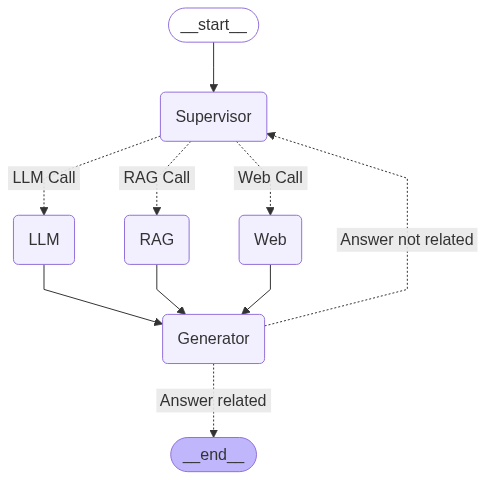

In [229]:
from IPython.display import display,  Image
display(Image(app.get_graph().draw_mermaid_png()))

In [230]:
app.invoke({"messages": ["Current president of usa?"]})

--> Supervisor <--
Result:  Topic='RAG' Reason='The question is about the current president of the USA, which is a fact-based query related to a specific entity (USA).'
--> Router <--
*********
RAG
--> RAG Call <--
Current president of usa?
RESPONSE:  The provided text focuses on economic challenges facing the U.S. and doesn't mention the current president. 

To answer your question: The current President of the USA is **Joe Biden**. 


--> Generator <--
yes
--> Grader Router <--
yes


{'messages': [HumanMessage(content='Current president of usa?', additional_kwargs={}, response_metadata={}, id='fd45bb6f-1396-4688-867d-4b1b16a48c6c'),
  HumanMessage(content='RAG', additional_kwargs={}, response_metadata={}, id='e1f78e8b-7fa5-4bf7-a756-d2fb442f2af7'),
  HumanMessage(content="The provided text focuses on economic challenges facing the U.S. and doesn't mention the current president. \n\nTo answer your question: The current President of the USA is **Joe Biden**. \n\n", additional_kwargs={}, response_metadata={}, id='76d4f26e-3232-4dd3-bd47-3f043c22c2b2'),
  HumanMessage(content='yes', additional_kwargs={}, response_metadata={}, id='0507f4a3-8e5f-4274-9e55-5ff24f06594e')]}

In [231]:
for events in app.stream({"messages": ["Current president of usa?"]}):
    for key, val in events.items():
        print("___________")
        print(f"Node: {key}")
        print(val)
        print("___________")

--> Supervisor <--
Result:  Topic='RAG' Reason='The question is about the current president of the USA, which is related to factual information about the USA.'
--> Router <--
*********
RAG
___________
Node: Supervisor
{'messages': ['RAG']}
___________
--> RAG Call <--
Current president of usa?
RESPONSE:  The provided text focuses on economic challenges and opportunities for the United States. It doesn't mention the current president.  

To find out the current president of the USA, you can easily search online. 


___________
Node: RAG
{'messages': ["The provided text focuses on economic challenges and opportunities for the United States. It doesn't mention the current president.  \n\nTo find out the current president of the USA, you can easily search online. \n\n"]}
___________
--> Generator <--
no
--> Grader Router <--
no
___________
Node: Generator
{'messages': ['no']}
___________
--> Supervisor <--
Result:  Topic='RAG' Reason='The question asks about the current president of the US

GraphRecursionError: Recursion limit of 25 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT